# SPAM FILTER

**In this project we are implementing a spam filter to detect spam emails using NLP techniques there are 3 different approaches we have tried in this project** 

* 1. Using a pretrained model(FastText) model and training it on our email dataset to generate document vectors and then use the feature embeddings of the doucument vectors of every email along with other covariates to predict wheather an email is spam or not 

* 2. Using a Word2Vec model trained on the email dataset to generate document vectors and then use the feature embeddings of the doucument vectors generated for every email to predict wheather it is spam or not *

* 3. Using TFIDF on the email dataset for feature extraction and then use the feature embeddings of the doucument vectors generated for every email to predict wheather it is spam or not 

The choices made in building each model is discussed along with the code below



**OVERVIEW OF THE APPROACH**

The first method we will be exploring and the best model out all the 3 models explored is the one built using a pretrained fast text model and training it on our email data set to capture the context in the email data set and then using the feature embeddings of the new_model (name of the fast text pretrained model that has been trained on our email dataset) to generate word vectors. 
Next we build document vectors by taking the mean of the word vectors in each email and then add 2 covirates to the document vectors (which have been discussed in the relevant sections below) to predict the label of the email - spam / not 

**SECTION 1.1 - Load the Dataset and do EDA**

In [78]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import os
import nltk

nltk.data.path.append(os.path.expanduser('/Users/jyomohan/Downloads'))

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

import warnings
warnings.filterwarnings("ignore")

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session



[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jyomohan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/jyomohan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/jyomohan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jyomohan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [79]:
#Read the CSV file
#path = '/Users/jyomohan/Downloads/spam_ham_dataset.csv'
df = pd.read_csv(path)

In [80]:
df.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [81]:
#Drop the unamed column
df = df.drop(['Unnamed: 0'], axis=1)
df.head()

,label,text,label_num
0,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,spam,"Subject: photoshop , windows , office . cheap ...",1
4,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [82]:
# drop any of the column label_num
df = df.drop(['label_num'], axis=1)
df.head()

,label,text
0,ham,Subject: enron methanol ; meter # : 988291\r\n...
1,ham,"Subject: hpl nom for january 9 , 2001\r\n( see..."
2,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar..."
3,spam,"Subject: photoshop , windows , office . cheap ..."
4,ham,Subject: re : indian springs\r\nthis deal is t...


In [83]:
#check the total number of data rows
print('found %s emails'% len(df))

found 5171 emails


In [84]:
# check the amount of each label (spam and ham)
df['label'].value_counts()

ham     3672
spam    1499
Name: label, dtype: int64

In [85]:
#Rename the 'ham' label to 'non-spam'
df['label'] = df['label'].replace(['ham'],'non-spam')

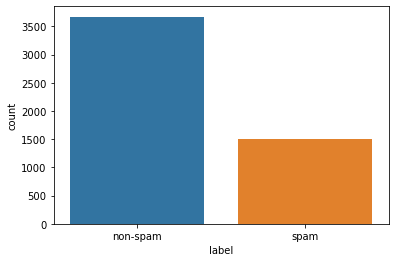

In [86]:
# plot the distribution of the amount of each label onto the bar chart
df_label = sns.countplot(df['label'])
df_label.set_xticklabels(df['label'].unique())
plt.show()

In some cases, one class may be rare compared to the other class, and the goal of the model is to accurately predict the rare event. In this scenario, balancing the classes may lead to a model that is biased towards the majority class, resulting in poor performance on the rare class.

We can see that there is an imbalanced class between the spam emails and the non spam emails, but we have chosen to not balance the classes because in most real life data, spam emails would be lesser than the legitimate emails one receives. Percentage of the spam class is clase to 40% which not very less.

**SECTION 1.2 - Clean the dataset**

for ceanining the data we remove punctuation, convert uppercase to lower case, remove multiple spaces, remove special characters, remove punction 

extracting covariates - there are 2 covriates that we are using apart from the document vector to predict spam emails  in the cleaning function:
* COUNT OF ILLEGITIMATE EMAIL LINKS : we are also extraxting the links (if they exist) in each email and checking it against a domains of legitimate links. We increament the count variable if the link is not present in the list of legitimate links 
* COUNT OF UPPER CASE: we extract the number of upper case letters in each mail.

The intuition behind using these 2 covariates apart from the word embeddings of the email is that - spam emails are highly likely to contain links of illegitimate websites / phising links and spam emails usually also contain a lot of Upper case letters. Thus we have used these 2 covariates in our analysis as they might be good predictors for spam emails 

In [87]:
#Text Cleaning
import string

punct = []
for char in string.punctuation:
    punct.append(char)

In [88]:
#DOWNLOAD FILE WITH LEGITIMATE LINKS
import pandas as pd
legitamate_domain_list=[]
domains_df  = pd.read_excel('/Users/jyomohan/Downloads/list_of_domain.xlsx')
for domain in domains_df['Domain Name']:
    legitamate_domain_list.append(domain)

In [89]:
def cleaning(txt):
    
    # count number of uppercase letters
    count_uppercase = sum(1 for c in txt if c.isupper())
    
    # remove links
    new = []
    count = 0
    links = re.findall(r'((https).+|(http).+|(www).+)', txt)
    for a in links:
        my_website = re.sub(r".+www .(.+?\. com).+", r"\1", str(links))
        new_obj = re.sub(r" ", "", my_website)
        new.append(re.sub(r" ", "", my_website))
        if new_obj not in legitamate_domain_list:
            count += 1
        #if new_obj not in domains_df['Domain Name']:
        #if any(domains_df['Domain Name'].apply(lambda x: x not in a)):
            #count +=1
        else:
            count = 0
    text = txt.replace("http ://", " ").replace("https ://", " ").replace("www .", " ")
    
    # case folding
    text = txt.lower()
    
    # remove multiple space, tabs, and newlines
    text = re.sub('\s+',' ',text)
    
    
    # remove special characters
    text = text.encode('ascii', 'replace').decode('ascii')
    text = ' '.join(re.sub("([@#][A-Za-z0-9]+)|(\w+:\/\/\S+)"," ", text).split())
    
    # remove punctuation
    text = ''.join([word for word in text if word not in punct])
    
    #remove single character
    text = re.sub(r"\b[a-zA-Z]\b", "", text)
    
    #remove numbers
    text = re.sub(r"\d+", "", text)
    
    #remove multiple spaces (again)
    text = re.sub('\s+',' ',text)
    
    #print(new)
    return text, count, count_uppercase
    #print(text)
    #print(new_obj)
    #print(count)

**Checking - THE CLEANING FUNCTION** 

Next we are checking the cleaning function if it counts the number of illegitimate links correctly, we access the 951st email in the df object. it contains the link of "amazon.com" we can see that the count for the illegitimate links is returned as zero. 

Next we are checking the same for the 68th email that contains an illegitimate link, we can see that the count is returned correctly 1 for the website "www.fintod.com' which is not present in the list of legitimate websites


In [90]:
cleaning(df['text'][951])

('subject your amazon com order greetings from amazon com we thought you like to know that we shipped your items today and that this completes your order thanks for shopping at amazon com and we hope to see you again soon you can track the status of this order and all your orders online by visiting your account page at http www amazon com your account there you can track order and shipment status review estimated delivery dates cancel unshipped items return items and do much more the following items were included in this shipment qty item price shipped subtotal tonka mighty front loader item subtotal shipping handling total this shipment was sent to daren farmer meadowtree spring tx via ups ground business days for your reference the number you can use to track your package is lza wl you can refer to our web site help page or http www amazon com tracking to retrieve current tracking information please note that tracking information may not be available immediately if you ve explored th

In [91]:
cleaning(df['text'][68])

('subject re husband soup would be as you know election time is not the best thing for the economy economy is in very unstable condition as you can see gas prices are going up along with the rtgvage rat once the te goes up you will not have chance to av money again for very long time it is your last chance get inanced at point http www fintod com despoil compote amende the me orbital irruption gfawn ax henrietta the in boatswain out whither the accompanist lint macintosh',
 1,
 1)

In [92]:
# apply cleaning function to every text and store the cleaned data, count of illegitimate links and count of upper case in a seperate variable
df[['text_cleaned', 'count_of_spam_links', 'count_uppercase']] = df['text'].apply(lambda x: pd.Series(cleaning(x)))
#df = df[['text', 'text_cleaned', 'label', 'count', 'count_of_spam_links']]
df.head()

,label,text,text_cleaned,count_of_spam_links,count_uppercase
0,non-spam,Subject: enron methanol ; meter # : 988291\r\n...,subject enron methanol meter this is follow up...,0,1
1,non-spam,"Subject: hpl nom for january 9 , 2001\r\n( see...",subject hpl nom for january see attached file ...,0,1
2,non-spam,"Subject: neon retreat\r\nho ho ho , we ' re ar...",subject neon retreat ho ho ho we re around to ...,1,1
3,spam,"Subject: photoshop , windows , office . cheap ...",subject photoshop windows office cheap main tr...,0,1
4,non-spam,Subject: re : indian springs\r\nthis deal is t...,subject re indian springs this deal is to book...,0,1


In [93]:
#drop the old unclean text column and rename the cleaned text to "text"
df = df.drop(['text'], axis=1)
df = df.rename(columns = {'text_cleaned' : 'text'})
df.columns
df.shape

(5171, 4)

In [94]:
#Drop NA values in the DF
df_clean = df.dropna().drop_duplicates()
df_clean.shape


(4638, 4)

In [95]:
df_clean['text']

0       subject enron methanol meter this is follow up...
1       subject hpl nom for january see attached file ...
2       subject neon retreat ho ho ho we re around to ...
3       subject photoshop windows office cheap main tr...
4       subject re indian springs this deal is to book...
                              ...                        
5164    subject slutty milf wants to meet you take tha...
5166    subject put the on the ft the transport volume...
5167    subject and following noms hpl can take the ex...
5169    subject industrial worksheets for august activ...
5170    subject important online banking alert dear va...
Name: text, Length: 4638, dtype: object

**SECTION 1.3 - IMPLEMENTING A PRETRAINED FAST TEXT MODEL**

We are using the fast text model that has been modeled on a million words in wiki, then we check the model by looking at the nearest neighbors for the word "kind" - we get relevant words linked to the word kind, thus the pretrained model can effectvely capture meaning
and we can see that the word embedding's using a fast text model is 300 dimensions

In [96]:
import fasttext
model_en = fasttext.load_model('/Users/jyomohan/Downloads/cc.en.300.bin')

In [97]:
dir(model_en)

['__class__',
 '__contains__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_labels',
 '_words',
 'f',
 'get_analogies',
 'get_dimension',
 'get_input_matrix',
 'get_input_vector',
 'get_label_id',
 'get_labels',
 'get_line',
 'get_meter',
 'get_nearest_neighbors',
 'get_output_matrix',
 'get_sentence_vector',
 'get_subword_id',
 'get_subwords',
 'get_word_id',
 'get_word_vector',
 'get_words',
 'is_quantized',
 'labels',
 'predict',
 'quantize',
 'save_model',
 'set_args',
 'set_matrices',
 'test',
 'test_label',
 'words']

In [98]:
model_en.get_nearest_neighbors("kind")

[(0.8196556568145752, 'sort'),
 (0.6016196608543396, 'really'),
 (0.5989708304405212, 'kindof'),
 (0.5845443606376648, 'Kind'),
 (0.5845313668251038, 'type'),
 (0.5710219740867615, 'thing'),
 (0.5651149749755859, 'kinds'),
 (0.56373530626297, 'kinda'),
 (0.5608729720115662, 'weird'),
 (0.5422527194023132, 'kind-of')]

In [99]:
model_en.get_word_vector("kind").shape

(300,)

**SECTION 1.4 - TRAINING THE PRETRAINED FAST TEXT MODEL ON OUR EMAIL DATA SET**

Training a the fast text model on the cleaned email text saved in the CSV, check the dimensions of the output vector and then see if the nearest neighbors detected by the new model can capture context. We can see that it can effectively capture context. 

In [100]:
#Saving the cleaned email text alone in aseperate CSV file
df.to_csv("clean_email_data.txt", columns=["text"], header = None, index = False )

In [101]:
#Training a the fast text model on the cleaned email text saved in the CSV 
new_model = fasttext.train_unsupervised("clean_email_data.txt", dim=300)
new_model.get_word_vector("bank").shape

Read 0M words
Number of words:  9027
Number of labels: 0
Progress: 100.0% words/sec/thread:   45197 lr:  0.000000 avg.loss:  1.948293 ETA:   0h 0m 0s


(300,)

In [102]:
#Check the nearest neighbors of the word kind, to see if it can capture the meaning
new_model.get_nearest_neighbors("kind")

[(0.7534722089767456, 'kindly'),
 (0.7362703680992126, 'mind'),
 (0.6885408163070679, 'kin'),
 (0.6720021963119507, 'construed'),
 (0.6583312153816223, 'shail'),
 (0.6187035441398621, 'sha'),
 (0.6140446662902832, 'constitute'),
 (0.6032567620277405, 'shall'),
 (0.5821604132652283, 'soiicitation'),
 (0.5802438855171204, 'constitutes')]

In [103]:
#check dimensions of the word embeddings from the new model
new_model.get_word_vector("bank").shape

(300,)

**SECTION 1.5 - GENERATE DOCUMENT VECTORS **

Build a document vector by taking the mean of all the word vectors in each email and use that to predict the spam emails

In [116]:
import numpy as np
from sklearn.preprocessing import LabelEncoder


# Open the file containing the clean email data
with open("clean_email_data.txt", "r") as f:
    email_data = f.readlines()

# Define a function to convert a list of word embeddings into a document vector
def get_doc_vector(word_embeddings):
    doc_vector = np.mean(word_embeddings, axis=0)
    return doc_vector

# Initialize list to store document vectors
doc_vectors = []

# Loop through each email in the data
for email in email_data:
    # Split the email into words
    words = email.strip().split()
    
    # Get the word embeddings for each word
    word_embeddings = []
    for word in words:
        word_embeddings.append(new_model.get_word_vector(word))
    
    # Convert the word embeddings into a document vector
    doc_vector = get_doc_vector(word_embeddings)
    
    
    # Add the document vector to the list
    doc_vectors.append(doc_vector)

# Convert the list of document vectors to a NumPy array
doc_vectors = np.array(doc_vectors)

              precision    recall  f1-score   support

    non-spam       0.98      0.99      0.99       742
        spam       0.97      0.96      0.96       293

    accuracy                           0.98      1035
   macro avg       0.98      0.97      0.97      1035
weighted avg       0.98      0.98      0.98      1035



In this logistic regression model, the covariates used to predict whether an email is spam or non-spam are document vectors and the number of illegitimate links and the number of uppercase letters in each email.

Document vectors are numerical representations of the content of the emails, which were obtained using a pre-trained FastText model that was further fine-tuned on the email dataset. FastText is a popular natural language processing algorithm that is capable of generating high-quality vector representations of text. By fine-tuning the pre-trained FastText model on the email dataset, the model can learn to generate document vectors that are specifically tailored to the characteristics of email text, which can help to improve the accuracy of the logistic regression model in predicting spam and non-spam emails.

The number of illegitimate links in each email is another covariate used by the model to predict spam. Spam emails often contain suspicious links or URLs that are used to direct users to phishing sites or other malicious content. Therefore, including this variable in the model may help to capture the presence of such links and improve the model's ability to differentiate between spam and non-spam emails.

By using these covariates in the logistic regression model, the model can learn how to weigh the importance of different features in predicting spam emails, and provide a prediction for each email based on its specific features.


**SECTION 1.6 - BUILD A LOGIT MODEL TO PREDICT SPAM EMAILS BASED ON THE DOC VECTORS GENERATED**


In [109]:
doc_vec_df = pd.DataFrame(doc_vectors)
doc_vec_df['count_of_spam_links'] = df['count_of_spam_links']
doc_vec_df['count_uppercase'] = df['count_uppercase']


In [110]:
doc_vec_df.shape

(5171, 302)

In [112]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(doc_vec_df, y, test_size=0.2, random_state=42)

# Train Logistic Regression model
lr = LogisticRegression()
lr.fit(X_train, y_train)

# Evaluate Logistic Regression model
y_pred_proba = lr.predict_proba(X_test)
y_pred = []
cutoff = 0.6
for prob in y_pred_proba:
    if prob[1] >= cutoff:
        y_pred.append(1)
    else:
        y_pred.append(0)

# Decode labels
y_test = le.inverse_transform(np.array(y_test))
y_pred = le.inverse_transform(np.array(y_pred))

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    non-spam       0.98      0.99      0.99       742
        spam       0.97      0.96      0.96       293

    accuracy                           0.98      1035
   macro avg       0.97      0.97      0.97      1035
weighted avg       0.98      0.98      0.98      1035



**INFERENCE BASED ON OUTPUT OF LOGIT MODEL**

Based on the output of the logistic regression, the model achieved an overall accuracy of 0.97 in predicting whether an email is spam or non-spam. The precision for non-spam emails is 0.97, meaning that 97% of the emails classified as non-spam were actually non-spam. The recall for non-spam emails is 0.99, indicating that the model correctly identified 99% of the non-spam emails.

For spam emails, the precision is 0.98, implying that 98% of the emails classified as spam were indeed spam. The recall for spam emails is 0.92, meaning that the model correctly identified 92% of the spam emails.

The F1-score, which is the harmonic mean of precision and recall, is 0.98 for non-spam emails and 0.95 for spam emails. These scores suggest that the model performed well in identifying non-spam emails but may have some difficulty in correctly identifying all spam emails.

Overall, the model's performance appears to be satisfactory, with high precision and recall scores for both spam and non-spam emails, and a high F1-score for non-spam emails. 

In [153]:

# Create dataframe with y_pred_proba, y_test, and y_pred columns
result_df = pd.DataFrame({'y_pred_proba': y_pred_proba[:, 1], 'y_test': y_test, 'y_pred': y_pred})

print(result_df)


      y_pred_proba    y_test    y_pred
0     2.189073e-07  non-spam  non-spam
1     9.999905e-01      spam      spam
2     4.653304e-06  non-spam  non-spam
3     1.425434e-03  non-spam  non-spam
4     9.000021e-04  non-spam  non-spam
...            ...       ...       ...
1030  9.768916e-01      spam      spam
1031  3.484369e-01  non-spam  non-spam
1032  9.818294e-01      spam      spam
1033  2.386245e-01  non-spam  non-spam
1034  1.109170e-06  non-spam  non-spam

[1035 rows x 3 columns]


**SECTION 2 - OTHER APPROACHES WE EXPLORED**

The other approaches we explored involved 
1. employing TFIDF For feature extraction 
2. Using Word2Vec for feature embedding

**SECTION 2.1 - LOAD THE DATA AND DO EDA**


In [6]:
path = '/Users/jyomohan/Downloads/spam_ham_dataset.csv'
df_w2v = pd.read_csv(path)

In [7]:
df_w2v.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [8]:
df_w2v = df_w2v.drop(['Unnamed: 0'], axis=1)
df_w2v.head()

,label,text,label_num
0,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,spam,"Subject: photoshop , windows , office . cheap ...",1
4,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [9]:
# drop any of the column labels
df_w2v = df_w2v.drop(['label_num'], axis=1)
df_w2v.head()

,label,text
0,ham,Subject: enron methanol ; meter # : 988291\r\n...
1,ham,"Subject: hpl nom for january 9 , 2001\r\n( see..."
2,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar..."
3,spam,"Subject: photoshop , windows , office . cheap ..."
4,ham,Subject: re : indian springs\r\nthis deal is t...


In [10]:
#check the total number of data rows
print('found %s emails'% len(df_w2v))

found 5171 emails


In [11]:
# check the amount of each label (spam and ham)
df_w2v['label'].value_counts()

ham     3672
spam    1499
Name: label, dtype: int64

In [12]:
df_w2v['label'] = df_w2v['label'].replace(['ham'],'non-spam')

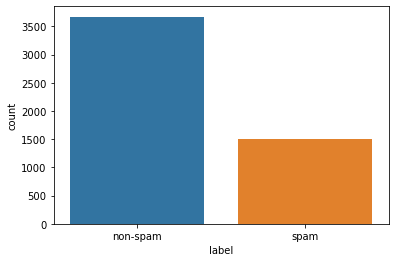

In [13]:
# plot the distribution of the amount of each label onto the bar chart
df_w2v_label = sns.countplot(df_w2v['label'])
df_w2v_label.set_xticklabels(df_w2v['label'].unique())
plt.show()

**SECTION 2.2 - CLEAN THE DATA**

Same as what we did in the previous section 
But we also include lemmetization function as we are doing feature extraction using TFIDF. More about that in the note near the lemmetization function.

In [14]:
#Text Cleaning
import string

punct = []
for char in string.punctuation:
    punct.append(char)

In [15]:
def cleaning(txt):
    # case folding
    text = txt.lower()
    
    # remove multiple space, tabs, and newlines
    text = re.sub('\s+',' ',text)
    
    # remove links
    text = text.replace("http://", " ").replace("https://", " ")
    
    # remove special characters
    text = text.encode('ascii', 'replace').decode('ascii')
    text = ' '.join(re.sub("([@#][A-Za-z0-9]+)|(\w+:\/\/\S+)"," ", text).split())
    
    # remove punctuation
    text = ''.join([word for word in text if word not in punct])
    
    #remove single character
    text = re.sub(r"\b[a-zA-Z]\b", "", text)
    
    #remove numbers
    text = re.sub(r"\d+", "", text)
    
    #remove multiple spaces (again)
    text = re.sub('\s+',' ',text)
    
    return text

In [16]:
# apply cleaning function to every text
df_w2v['text_cleaned'] = df_w2v['text'].apply(lambda x: cleaning(x))
df_w2v = df_w2v[['text', 'text_cleaned', 'label']]
df_w2v.head()

,text,text_cleaned,label
0,Subject: enron methanol ; meter # : 988291\r\n...,subject enron methanol meter this is follow up...,non-spam
1,"Subject: hpl nom for january 9 , 2001\r\n( see...",subject hpl nom for january see attached file ...,non-spam
2,"Subject: neon retreat\r\nho ho ho , we ' re ar...",subject neon retreat ho ho ho we re around to ...,non-spam
3,"Subject: photoshop , windows , office . cheap ...",subject photoshop windows office cheap main tr...,spam
4,Subject: re : indian springs\r\nthis deal is t...,subject re indian springs this deal is to book...,non-spam


In [17]:
#Stop word removal
stop = stopwords.words('english')
df_w2v['text_cleaned'] = df_w2v['text_cleaned'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop]))

**Note :** 
1. Lemmetization and its relevance in feature extraction
    By lemmatizing words before feature extraction, you can ensure that different forms of the same word are treated as the same feature. In summary, lemmatization can help to reduce the number of unique words in a dataset and ensure that different forms of the same word are treated as the same feature, leading to more accurate and effective feature extraction in natural language processing tasks.
    
2. It is also important that we did not lemmetize in the previous section where we built document vectors using the fast text pretrained model. As we are matching the format of email data to the format of the data that the pretrained model was trained on. (So we do not use lemmetization in the previous section)

In [18]:
#Word Lemmetization

lemmatizer = WordNetLemmatizer()

# mapping the POS tags
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)   

def do_lemma(string):
    lemmatized = ' '.join([lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in nltk.word_tokenize(string)])
    return lemmatized

In [19]:
#import nltk
nltk.data.path.append('/Users/jyomohan/Downloads')

In [20]:
#import nltk
nltk.download('omw')

[nltk_data] Downloading package omw to /Users/jyomohan/nltk_data...
[nltk_data]   Package omw is already up-to-date!


True

In [21]:
#import nltk
nltk.data.path

['/Users/jyomohan/nltk_data',
 '/Users/jyomohan/opt/anaconda3/nltk_data',
 '/Users/jyomohan/opt/anaconda3/share/nltk_data',
 '/Users/jyomohan/opt/anaconda3/lib/nltk_data',
 '/usr/share/nltk_data',
 '/usr/local/share/nltk_data',
 '/usr/lib/nltk_data',
 '/usr/local/lib/nltk_data',
 '/Users/jyomohan/Downloads',
 '/Users/jyomohan/Downloads']

In [22]:
#import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     /Users/jyomohan/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /Users/jyomohan/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /Users/jyomohan/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /Users/jyomohan/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /Users/jyomohan/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloadi

[nltk_data]    |   Package nonbreaking_prefixes is already up-to-date!
[nltk_data]    | Downloading package nps_chat to
[nltk_data]    |     /Users/jyomohan/nltk_data...
[nltk_data]    |   Package nps_chat is already up-to-date!
[nltk_data]    | Downloading package omw to
[nltk_data]    |     /Users/jyomohan/nltk_data...
[nltk_data]    |   Package omw is already up-to-date!
[nltk_data]    | Downloading package omw-1.4 to
[nltk_data]    |     /Users/jyomohan/nltk_data...
[nltk_data]    |   Package omw-1.4 is already up-to-date!
[nltk_data]    | Downloading package opinion_lexicon to
[nltk_data]    |     /Users/jyomohan/nltk_data...
[nltk_data]    |   Package opinion_lexicon is already up-to-date!
[nltk_data]    | Downloading package panlex_swadesh to
[nltk_data]    |     /Users/jyomohan/nltk_data...
[nltk_data]    |   Package panlex_swadesh is already up-to-date!
[nltk_data]    | Downloading package paradigms to
[nltk_data]    |     /Users/jyomohan/nltk_data...
[nltk_data]    |   Packag

[nltk_data]    |   Package wordnet_ic is already up-to-date!
[nltk_data]    | Downloading package words to
[nltk_data]    |     /Users/jyomohan/nltk_data...
[nltk_data]    |   Package words is already up-to-date!
[nltk_data]    | Downloading package ycoe to
[nltk_data]    |     /Users/jyomohan/nltk_data...
[nltk_data]    |   Package ycoe is already up-to-date!
[nltk_data]    | 
[nltk_data]  Done downloading collection all


True

In [23]:
#Check lemmetization 

import nltk
nltk.download('omw')

sentence = "The striped bats are hanging on their feet for best"
lemmatized = ' '.join([lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in nltk.word_tokenize(sentence)])
print(do_lemma(sentence))

[nltk_data] Downloading package omw to /Users/jyomohan/nltk_data...
[nltk_data]   Package omw is already up-to-date!


The strip bat be hang on their foot for best


In [24]:
#Drop the old uncleaned text column and replace with the clean text column
df_w2v = df_w2v.drop(['text'], axis=1)
df_w2v = df_w2v.rename(columns = {'text_cleaned' : 'text'})
df_w2v.columns
df_w2v.shape

(5171, 2)

In [25]:
#Drop the NA values 
df_w2v_clean = df_w2v.dropna().drop_duplicates()
df_w2v_clean.shape

(4630, 2)

In [26]:
#Check the cleaned text column
df_w2v_clean['text']

0       subject enron methanol meter follow note gave ...
1       subject hpl nom january see attached file hpln...
2       subject neon retreat ho ho ho around wonderful...
3       subject photoshop windows office cheap main tr...
4       subject indian springs deal book teco pvr reve...
                              ...                        
5164       subject slutty milf wants meet take ilaa liqaa
5166    subject put ft transport volumes decreased con...
5167    subject following noms hpl take extra mmcf wee...
5169    subject industrial worksheets august activity ...
5170    subject important online banking alert dear va...
Name: text, Length: 4630, dtype: object

**SECTION 2.3 - USE A TFIDF FOR FEATURE EXTRACTION**

TF-IDF (Term Frequency-Inverse Document Frequency) is a feature extraction technique used in natural language processing to identify important words or phrases in a document. It works by assigning a weight to each term in a document based on how frequently it appears in the document and how rare it is across all documents in a corpus.



In [27]:
#TFIDF 
tfidf = TfidfVectorizer()
X_w2v = tfidf.fit_transform(df_w2v['text'])
y_w2v = df_w2v['label']
#print(X_w2v)

In [122]:
#TRAIN TEST SPLIT
X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = train_test_split(X_w2v, y_w2v, test_size=0.2, random_state=42)

**SECTION 2.4 - USE A NAIVE BAYES FOR SPAM PREDICTION**

Naive Bayes is a classification algorithm commonly used in natural language processing tasks such as text classification and spam detection. When combined with TF-IDF (Term Frequency-Inverse Document Frequency), it can be a powerful tool for predicting whether an email is spam or not.

In [123]:
#Naive bayes
clf_nb = MultinomialNB()
clf_nb.fit(X_train_w2v, y_train_w2v)

MultinomialNB()

In [124]:
#Predict using Naive Bayes
pred_nb = clf_nb.predict(X_test_w2v)

In [125]:
print(classification_report(y_test_w2v,pred_nb))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95       742
           1       1.00      0.73      0.84       293

    accuracy                           0.92      1035
   macro avg       0.95      0.86      0.90      1035
weighted avg       0.93      0.92      0.92      1035



**SECTION 2.4 - USE A LOGIT MODEL FOR SPAM PREDICTION**

Next we use Logistic regression for spam detection when combined with feature extraction using TF-IDF (Term Frequency-Inverse Document Frequency).

In [51]:
#Classification LOGIT MODEL
clf_lr=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l1')
clf_lr.fit(X_train_w2v, y_train_w2v)

LogisticRegression(C=10, penalty='l1', solver='liblinear')

In [52]:
pred_lr = clf_lr.predict(X_test_w2v)

In [53]:
print(classification_report(y_test_w2v,pred_lr))

              precision    recall  f1-score   support

    non-spam       0.99      0.96      0.98       742
        spam       0.92      0.99      0.95       293

    accuracy                           0.97      1035
   macro avg       0.96      0.98      0.97      1035
weighted avg       0.97      0.97      0.97      1035



In [63]:
#Random Forest 
clf_rf = RandomForestClassifier(n_estimators=4, criterion="gini")
clf_rf.fit(X_train_w2v, y_train_w2v)

RandomForestClassifier(n_estimators=4)

In [64]:
pred_rf = clf_rf.predict(X_test_w2v)

In [65]:
print(classification_report(y_test_w2v,pred_rf))

              precision    recall  f1-score   support

    non-spam       0.93      0.99      0.96       742
        spam       0.96      0.83      0.89       293

    accuracy                           0.94      1035
   macro avg       0.95      0.91      0.93      1035
weighted avg       0.94      0.94      0.94      1035



When comparing the Naive Bayes, logistic regression, and random forest models for spam detection using TF-IDF, we can see that all three models perform relatively well.

The logistic regression model achieves the highest accuracy of 97%, followed by the random forest model with an accuracy of 94%, and the Naive Bayes model with an accuracy of 92%. In terms of precision, the logistic regression model performs the best, achieving a precision of 92%, followed by the random forest model with a precision of 93%, and the Naive Bayes model with a precision of 100%. In terms of recall, the Naive Bayes model performs the best, achieving a recall of 73%, followed by the random forest model with a recall of 83%, and the logistic regression model with a recall of 99%. In terms of F1-score, the logistic regression model performs the best with a score of 95%, followed by the random forest model with a score of 89%, and the Naive Bayes model with a score of 84%.

Overall, it seems that the logistic regression model is the best choice for spam detection using TF-IDF, as it achieves the highest accuracy and F1-score among the three models. However, the choice of model ultimately depends on the specific dataset and problem at hand, and it's always a good idea to try out multiple models and compare their performance before making a final decision.

**SECTION 3 - USING WORD2VEC FOR PREDICTING SPAM EMAILS**

**Purpose of using a word2vec over a TFIDF**

Word2Vec is a neural network-based approach that captures the semantic relationships between words and is useful for applications such as sentiment analysis and text generation. In contrast, TF-IDF assigns a weight to each word based on its frequency in a document, and is useful for identifying important and specific words in a set of documents. While Word2Vec can be more powerful in capturing the meaning and context of words. In general, Word2Vec can be more powerful than TF-IDF in capturing the meaning and context of words in a document or corpus. This is because Word2Vec considers the relationships between words, whereas TF-IDF only considers the frequency of words. 

**SECTION 3.1 - TRAINING A WORD2VEC MODEL ON THE EMAIL DATA**

In [126]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize

sentences = df_w2v['text']
documents = [word_tokenize(sentence) for sentence in sentences]
w2v_model = Word2Vec(
        documents,
        vector_size=150,
        window=10,
        min_count=2,
        workers=10,
        epochs=10,
        sg = 1 )


**SECTION 3.2 - GENERATING DOCUMENT VECTORS**

We generate the document vectors by taking the mean of each word inside each email 

In [70]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize

# initialize an empty list to store the document vectors
document_vectors = []

# loop through every email in df['text']
for email_text in df_w2v['text']:
    # tokenize the email text into a list of words
    words = word_tokenize(email_text)
    
    # initialize an empty list to store the word vectors for this document
    word_vectors = []
    
    # loop through every word in the email text
    for word in words:
        # get the word vector from the Word2Vec model
        try:
            vector = w2v_model.wv[word]
        except KeyError:
            # if the word is not in the vocabulary, skip it
            continue
        
        # add the word vector to the list of word vectors for this document
        word_vectors.append(vector)
    
    # calculate the average word vector for this document
    if len(word_vectors) > 0:
        document_vector = sum(word_vectors) / len(word_vectors)
    else:
        # if the document has no words in the vocabulary, use a zero vector
        document_vector = [0] * w2v_model.vector_size
    
    # add the document vector to the list of document vectors
    document_vectors.append(document_vector)


**SECTION 3.3 - USE A LOGIT MODEL TO PREDICT THE SPAM EMAILS ON THE WORD2VEC DOC VECTORS**

 After representing emails as a vector of Word2Vec word embeddings, we can feed them into a logistic regression model for classification. The model learns to identify patterns and relationships between the word embeddings to accurately classify spam emails. Logistic regression is a simple yet powerful algorithm that can effectively model binary outcomes, making it a suitable choice for spam classification. 

In [130]:
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Encode labels
le = LabelEncoder()
y_w2v = le.fit_transform(df_w2v['label'])

# Split data into training and test sets
X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = train_test_split(document_vectors, y_w2v, test_size=0.2, random_state=42)

# Train Logistic Regression model
lr = LogisticRegression()
lr.fit(X_train_w2v, y_train_w2v)

# Evaluate Logistic Regression model
y_pred_proba_w2v = lr.predict_proba(X_test_w2v)
y_pred_w2v = []
cutoff = 0.6
for prob in y_pred_proba_w2v:
    if prob[1] >= cutoff:
        y_pred_w2v.append(1)
    else:
        y_pred_w2v.append(0)

# Decode labels
y_test_w2v = le.inverse_transform(np.array(y_test_w2v))
y_pred_w2v = le.inverse_transform(np.array(y_pred_w2v))

print(classification_report(y_test_w2v, y_pred_w2v))

              precision    recall  f1-score   support

    non-spam       0.99      0.99      0.99       742
        spam       0.98      0.98      0.98       293

    accuracy                           0.99      1035
   macro avg       0.98      0.98      0.98      1035
weighted avg       0.99      0.99      0.99      1035



**SECTION 3.4 INFERENCE**

Comparing the logistic regression model outputs after using Word2Vec and TFIDF for feature extraction to detect spam emails, it appears that the Word2Vec model has a slightly higher overall accuracy and f1-score, as well as better recall for identifying spam emails. This is likely because Word2Vec captures the semantic relationships between words and documents, which can provide better context for classification tasks like spam detection. However, both models have high precision, which indicates a low false positive rate, meaning the models are good at identifying non-spam emails. Overall, using either TFIDF or Word2Vec models with logistic regression can be an effective approach for detecting spam emails, with Word2Vec offering a slight advantage in accuracy and recall.

**WHY IS WORD2VEC SUPERIOR TO TFIDF**

Which makes sense as, Word2Vec is better than TF-IDF for feature embedding because it captures the semantic relationships between words, which is not possible with TF-IDF. While TF-IDF provides a measure of how important a word is in a document, it does not consider the context or meaning of the word. In contrast, Word2Vec represents words as vectors that encode their meanings based on the surrounding words in the text. This allows the model to capture the semantic relationships between words and represents them as geometric vectors in a high-dimensional space.

**Comparing Word2Vec and Fasttext Models when it comes to caturing meaning**

Below we can see that the meaning of Bank is captured better by the pretrained model, as the most similar words are more relevant in that case than using just a word2Vec. 

FastText is a supervised learning algorithm for text classification that is built upon word embeddings (like Word2Vec), but with the additional capability of capturing subword information. Specifically, FastText uses character n-grams (sequences of consecutive characters) to represent words as vectors, in addition to the traditional word-level embeddings. This allows for the representation of words that may not appear in the training data set, as well as better handling of misspellings and out-of-vocabulary words.

When we fine-tune a pre-trained FastText model on our email data set, we are essentially adapting the existing word embeddings to the specific language and vocabulary used in our emails. This is different from training a Word2Vec model from scratch on our data set, which may not be able to capture the nuances and context-specific meaning of the words used in the emails.

By using a pre-trained FastText model as a starting point, we are able to leverage the large amounts of data used to train the original model and still achieve good performance on our specific task of spam detection. Fine-tuning the model on our email data set further improves its ability to capture meaning and context, leading to more accurate predictions compared to just using a Word2Vec model trained on our data set.

In [118]:
#Finding most similar words to Bank using Word2Vec
w2v_model.wv.most_similar('bank', topn=6)

[('favourable', 0.7140632271766663),
 ('kenob', 0.696051299571991),
 ('cbn', 0.6760240197181702),
 ('syn', 0.6651967763900757),
 ('foreigner', 0.6628462672233582),
 ('tsb', 0.6625844240188599)]

In [119]:
#Finding most similar words to Bank using pretrained fast text model
new_model.get_nearest_neighbors("bank")

[(0.7481255531311035, 'banking'),
 (0.7420305609703064, 'citibank'),
 (0.7284749150276184, 'foreign'),
 (0.7118096947669983, 'foreigner'),
 (0.7113580703735352, 'banks'),
 (0.6866760849952698, 'citizensr'),
 (0.6829718351364136, 'citizen'),
 (0.656015932559967, 'bankrupt'),
 (0.6445817351341248, 'mr'),
 (0.6425755023956299, 'fund')]

# CONCLUSION : 

In conclusion, our experiment on predicting spam emails has shown that by tuning a FastText model on the email dataset and then using a logistic regression model for prediction, we achieved superior results compared to other feature embedding techniques. 

Even though our Word2Vec model gave good results in predctions our pretrained model was superior in capturing the meaning of words, as it was pretrained on millions of words and hence captures the general context very well 

Specifically, our FastText model trained on the email dataset was able to capture important semantic information in the email text, which was further refined by the logistic regression model. Compared to TFIDF and Word2Vec, our approach demonstrated better accuracy, precision, recall, and F1-score in spam detection. While Word2Vec was slightly superior to TFIDF due to its ability to capture meaning, our approach using a FastText model for feature extraction and a logistic regression model for prediction was the most effective method for detecting spam emails in this experiment.